# Forecast Market Price By Using Time Series Methods in Stocks

## Import Library

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finviz.screener import Screener
from typing import List, Dict
from sklearn import logger
from pyfinviz.quote import Quote
from pyfinviz.screener import Screener
from pyfinviz.insider import Insider
import re
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from arch.unitroot import KPSS, ADF
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.forecasting.theta import ThetaModel

## Import dataset

In [131]:
# period is three years
end_date = datetime.today().date()

start_date = datetime(2020, 7, 19)
# start_date = end_date - relativedelta(years = 5)

df = yf.download(
  'NKTX',
  start = start_date,
  end = end_date
)


[*********************100%%**********************]  1 of 1 completed


In [132]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,36.610001,37.500000,35.599998,36.389999,36.389999,405600
2020-07-21,36.080002,37.500000,32.930000,33.599998,33.599998,137600
2020-07-22,33.779999,34.150002,30.700001,30.850000,30.850000,104300
2020-07-23,31.299999,31.870001,30.129999,30.350000,30.350000,63800
2020-07-24,31.240000,31.240000,28.299999,28.700001,28.700001,92800
...,...,...,...,...,...,...
2024-03-28,10.800000,11.370000,10.590000,10.810000,10.810000,1197000
2024-04-01,11.585000,11.839000,10.560000,10.820000,10.820000,1550700
2024-04-02,10.360000,10.480000,9.600000,9.890000,9.890000,929900


### Draw open price for NKTX

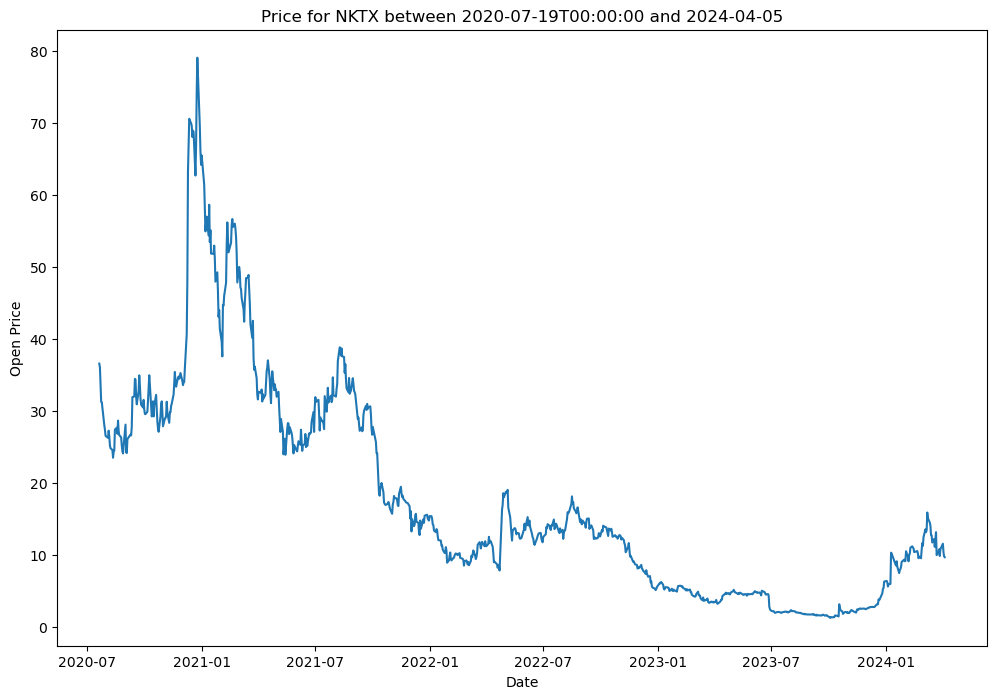

In [133]:
# plot grap of 'NKTX' open price for 5 years
fig, axes = plt.subplots(figsize = (12, 8))
plt.title('Price for NKTX between {} and {}'.format(start_date.isoformat(), end_date.isoformat()))
sns.lineplot(data = df, x = df.index,  y = 'Open')
# sns.lineplot(data = df, x = df.index, y = 'High')
# sns.lineplot(data = df, x = df.index, y = 'Low')
plt.ylabel('Open Price')
plt.show()

### Check autocorrelation 

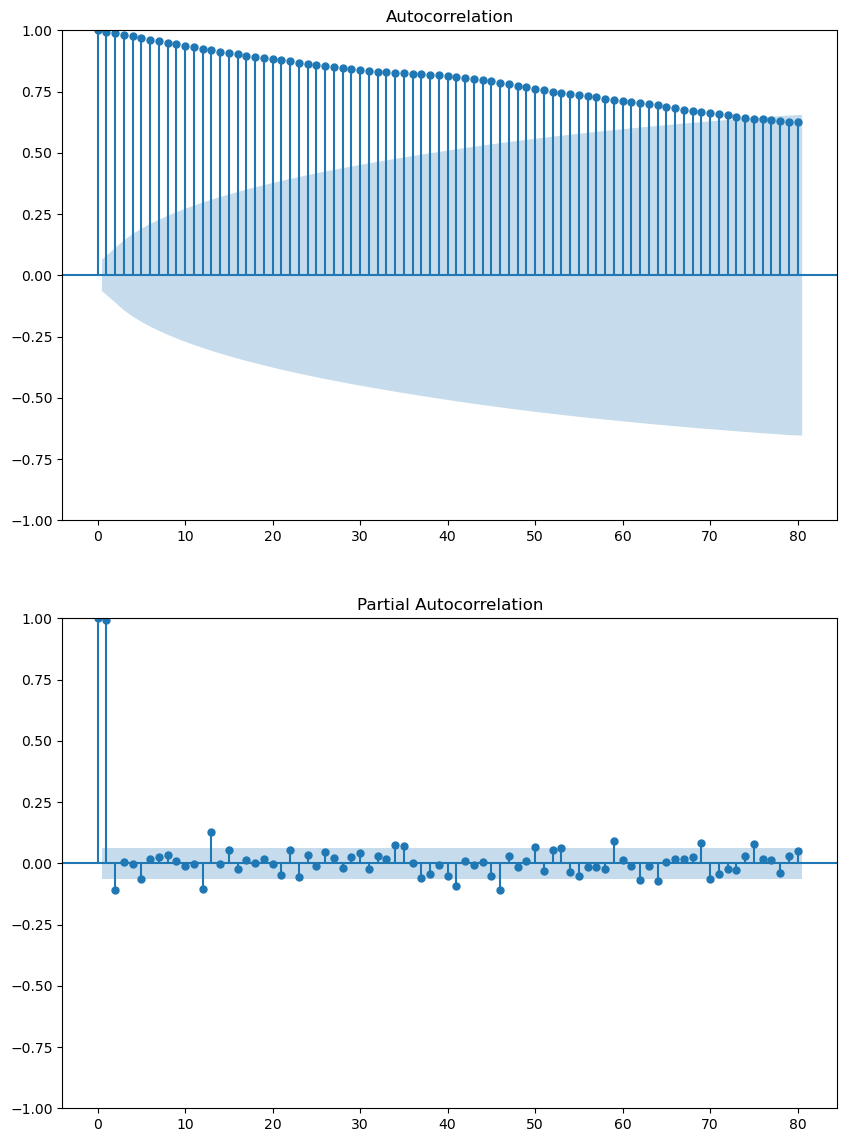

In [134]:
fig, axes = plt.subplots(2, 1, figsize = (10,14))
sm.graphics.tsa.plot_acf(df['Open'], lags = 80, ax= axes[0])  ## correlection of time series and time series which backward lag i 
sm.graphics.tsa.plot_pacf(df['Open'], lags = 80, ax= axes[1])  ## remove the inflence of the other time series between lags i 
plt.show()
# these graphs show that the correlation of time series with itself at lags of up to 80, within the interval of 74 days(approximately), prices is correlated closely

## resample data to frequent to 5 days 

In [135]:
df2 = df.asfreq('5d')

In [136]:
# resample data to 5 business days 
df1 = df.reset_index().resample(rule = '5d', on = 'Date')['Open'].mean()
df1

Date
2020-07-20    33.802000
2020-07-25    28.090000
2020-07-30    26.456667
2020-08-04    25.967500
2020-08-09    24.255000
                ...    
2024-03-11    13.188000
2024-03-16    11.870000
2024-03-21    11.218333
2024-03-26    10.496667
2024-03-31    10.366250
Freq: 5D, Name: Open, Length: 271, dtype: float64

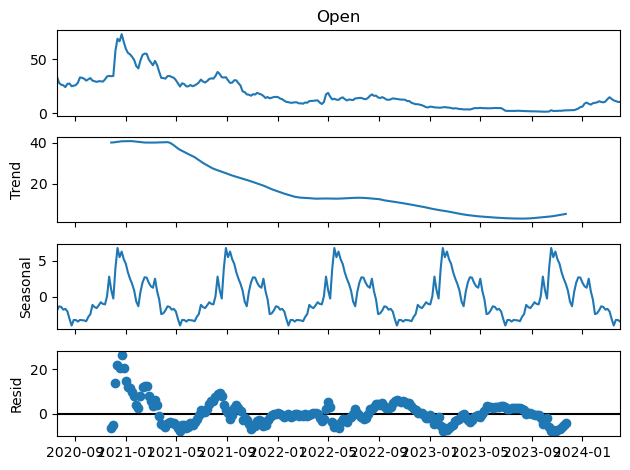

In [137]:
# check the seasonality and trend
res = seasonal_decompose(df1, model = 'additive', period = 52)
res.plot()
plt.show()

In [138]:
#  check the stationality 
ADF(df1, trend = 'c')
# the possiblity of not staitionality for this model is 47.1%
# the model is stationality

Test Statistic,-1.609
P-value,0.479
Lags,2


### Train the model

In [139]:
# use STLForecast to remove seasonality and then add it back 

mod = STLForecast(
  df1,
  sm.tsa.arima.ARIMA,
  model_kwargs = dict(order = (1, 0, 3), trend = 't')
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  271
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -552.857
Date:                Fri, 05 Apr 2024   AIC                           1117.714
Time:                        14:25:48   BIC                           1139.327
Sample:                    07-20-2020   HQIC                          1126.392
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0279      0.199      0.140      0.889      -0.363       0.418
ar.L1          0.9912      0.008    129.695      0.000       0.976       1.006
ma.L1          0.4020      0.047      8.564      0.0

### Forecasting

In [140]:
steps = 6
forecast_df = res.get_forecast(steps = steps).summary_frame()
forecast_df

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-04-05,12.200293,1.843219,8.587650,15.812936
2024-04-10,12.236309,3.161080,6.040706,18.431913
2024-04-15,12.216203,4.128627,4.124243,20.308163
2024-04-20,12.203788,5.037374,2.330716,22.076859
2024-04-25,12.191726,5.793008,0.837639,23.545813
2024-04-30,12.180015,6.449769,-0.461299,24.821330


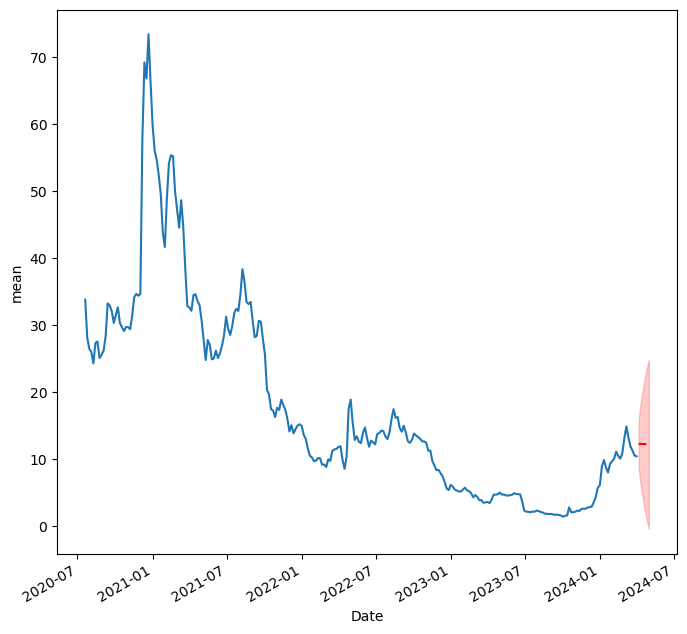

In [141]:
#draw the predict plot 
fig, axes = plt.subplots(figsize = (8, 8))
sns.lineplot(data = forecast_df, x = forecast_df.index, y = 'mean', linestyle = '--', c = 'red')
df1.plot(ax = axes)
axes.fill_between(x = forecast_df.index, y1 = forecast_df['mean_ci_lower'], y2 = forecast_df['mean_ci_upper'], color = 'r', alpha = 0.2)
plt.show()

### Exponential Smoothing Model

In [142]:
mod = sm.tsa.ExponentialSmoothing(endog = df1, trend = 'add')
res1 = mod.fit()
res1.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 33.88926559256842,
 'initial_trend': -0.08681871273018071,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [143]:
forecasts = pd.Series(res1.forecast(steps = steps))
forecasts

2024-04-05    10.279431
2024-04-10    10.192613
2024-04-15    10.105794
2024-04-20    10.018975
2024-04-25     9.932156
2024-04-30     9.845338
Freq: 5D, dtype: float64

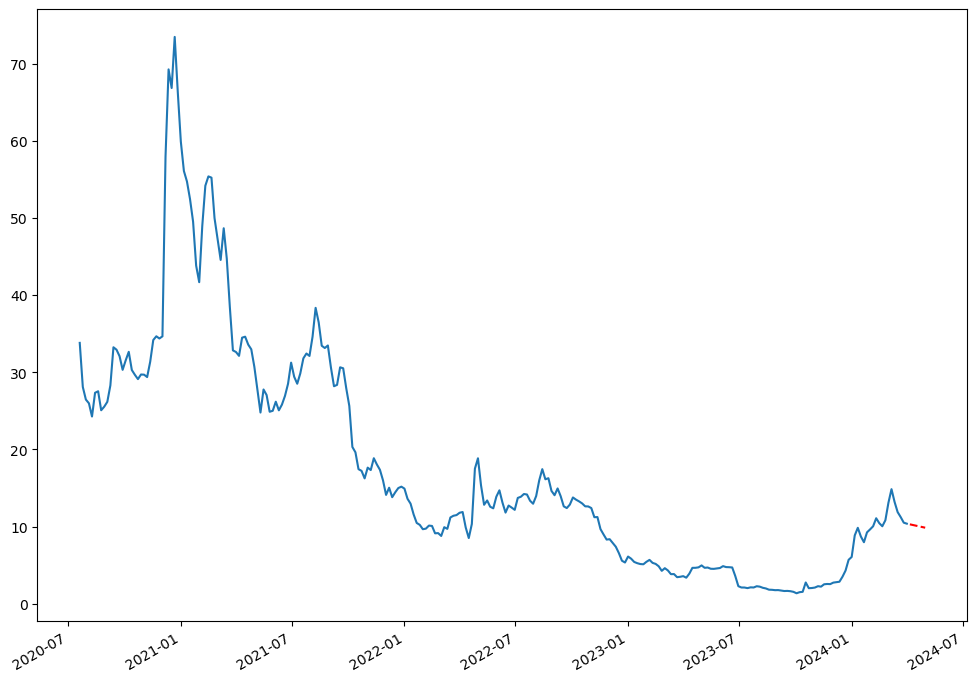

In [144]:
# plot the forecast
fig, axes = plt.subplots(figsize = (12, 9))
axes.plot(df1)
forecasts.plot(style = '--', ax= axes, c = 'r')
plt.show()

### Error analyse

In [145]:
train_length = int(len(df1) * 0.8)
tm = ThetaModel(df1[: train_length], method = 'auto', deseasonalize = True)
res2 = tm.fit()
forecasts2 = res2.forecast(steps = len(df1) - train_length)

In [146]:
forecasts2

2023-07-05    2.138358
2023-07-10    2.043916
2023-07-15    1.917319
2023-07-20    1.816271
2023-07-25    1.771518
2023-07-30    1.688582
2023-08-04    1.572886
2023-08-09    1.455016
2023-08-14    1.359510
2023-08-19    1.243050
2023-08-24    1.143751
2023-08-29    1.078933
2023-09-03    0.989370
2023-09-08    0.880632
2023-09-13    0.771675
2023-09-18    0.675104
2023-09-23    0.568781
2023-09-28    0.471231
2023-10-03    0.386349
2023-10-08    0.290159
2023-10-13    0.188378
2023-10-18    0.088333
2023-10-23   -0.009302
2023-10-28   -0.105488
2023-11-02   -0.201289
2023-11-07   -0.306235
2023-11-12   -0.409052
2023-11-17   -0.503876
2023-11-22   -0.595009
2023-11-27   -0.693708
2023-12-02   -0.779758
2023-12-07   -0.873809
2023-12-12   -0.998819
2023-12-17   -1.108264
2023-12-22   -1.196129
2023-12-27   -1.278351
2024-01-01   -1.378114
2024-01-06   -1.454027
2024-01-11   -1.546329
2024-01-16   -1.691403
2024-01-21   -1.807475
2024-01-26   -1.888383
2024-01-31   -1.961692
2024-02-05 

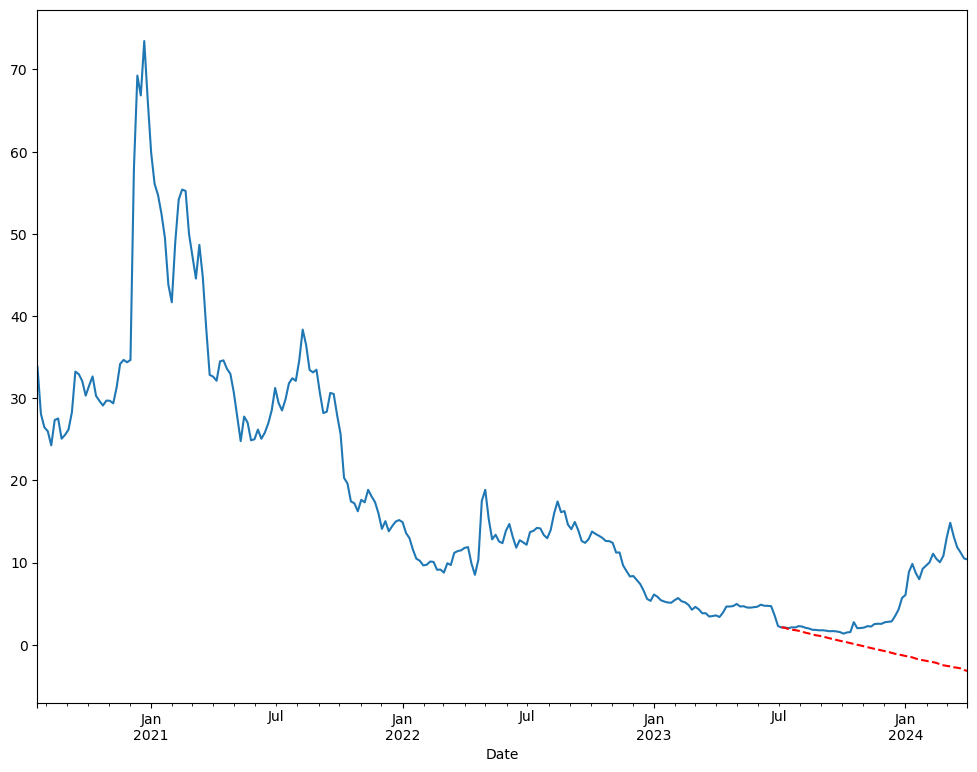

In [147]:
# plot the real data and forecast result
fig, axes = plt.subplots(figsize = (12, 9))
df1.plot(ax= axes)
forecasts2.plot(ax = axes, style = '--', color = 'r')
plt.show()

In [148]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(df1[train_length : ], forecasts2)
error

61.241233522047736